## mount to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/AICamp2023/MMPretrain

Mounted at /content/drive
/content/drive/MyDrive/AICamp2023/MMPretrain


## installaltion

In [2]:
!pip install -U openmim
!mim install mmengine
!mim install 'mmcv>=2.0.0rc3'
!mim install "mmpretrain[multimodal]>=1.0.0rc8"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 6.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.3/374.3 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.9/200.9 kB 26.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 MB 20.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━

## GPU information

In [3]:
import os
import mmcv
import mmengine
import torch

if torch.cuda.is_available():
    print('CUDA is available')
    device_count = torch.cuda.device_count()
    print(f'Total number of CUDA devices: {device_count}')
    for i in range(device_count):
        device_name = torch.cuda.get_device_name(i)
        print(f'Device {i}: {device_name}')
else:
    print('CUDA is not available')

CUDA is available
Total number of CUDA devices: 1
Device 0: NVIDIA A100-SXM4-40GB


## fetch ResNet-50 configs and weights

In [ ]:
! mim search mmpretrain --model resnet

--------------------------------------------------------------------------------
config id: resnet18_8xb16_cifar10
architecture                 resnet
batch_size                   128
cifar-10/top_1_accuracy      94.82
config                       configs/resnet/resnet18_8xb16_cifar10.py
epochs                       200
flops                        560000000
model                        resnet
paper                        URL,Title
parameters                   11170000
readme                       configs/resnet/README.md
training_data                cifar-10
training_resources           8x v100 gpus
training_techniques          sgd with momentum,weight decay
weight                       https://download.openmmlab.com/mmclassification/...
--------------------------------------------------------------------------------
config id: resnet34_8xb16_cifar10
architecture                 resnet
batch_size                   128
cifar-10/top_1_accuracy      95.34
config                       con

In [ ]:
!mim download mmpretrain --config resnetv1c50_8xb32_in1k --dest Configs

processing resnetv1c50_8xb32_in1k...
resnetv1c50_8xb32_in1k_20220214-3343eccd.pth exists in /content/drive/MyDrive/AICamp2023/MMPretrain/Configs
Successfully dumped resnetv1c50_8xb32_in1k.py to /content/drive/MyDrive/AICamp2023/MMPretrain/Configs


## prepare dataset

In [ ]:
import os
import shutil
import random
import numpy as np
from tqdm import tqdm

def data_split(images_dir, r_train=0.8):
    """split dataset into train and val with defined ratio"""
    random.seed(0); np.random.seed(0) # set seed 
    image_types = ['.jpg', '.jpeg', '.png', '.tif'] # supported image types
    file_names = sorted(os.listdir(images_dir), key=str.casefold) # obtain all file names
    file_names = [name for name in file_names if any(name.endswith(file_type) for file_type in image_types)] # filter for only image files
    
    train_size = int(len(file_names)*r_train) # training size
    validation_size = int(len(file_names)*(1-r_train)) # validation size
    
    file_names_shuffle = file_names.copy() # make a copy of list to prevent changes in place
    random.shuffle(file_names_shuffle) # random shuffle file names   
    train_names = file_names_shuffle[:train_size] # file names for training
    val_names = file_names_shuffle[train_size:train_size + validation_size] # file names for validation
    print(f'train size={train_size}, validation size={validation_size}')
    return train_names, val_names


def dataset_creator(data_root, r_train=0.8):
    """create train and val dataset"""
    data_root = os.path.normpath(data_root) # format string as path
    train_root = os.path.join(data_root, 'train') # train set root
    val_root = os.path.join(data_root, 'val') # validation set root

    subfolders = os.listdir(data_root) # get subfolder names under data root
    for subfolder in subfolders:
        subfolder_path = os.path.join(data_root, subfolder) # subfolder path
        train_names, val_names = data_split(subfolder_path, r_train=r_train) # file names for train and val
        destination_train_root = os.path.join(train_root, subfolder) # train class folder dir
        destination_val_root = os.path.join(val_root, subfolder) # val class folder dir
        os.makedirs(destination_train_root, exist_ok=True); os.makedirs(destination_val_root, exist_ok=True) # create the folders for the given class
        for name in train_names:
            source = os.path.join(subfolder_path, name) # source train image           
            destination = os.path.join(destination_train_root, name) # destination train image
            shutil.copy2(source, destination) # copy source and paste to destination
        for name in val_names:
            source = os.path.join(subfolder_path, name) # source validation image           
            destination = os.path.join(destination_val_root, name) # destination validation image
            shutil.copy2(source, destination) # copy source and paste to destination
    return None

dataset_creator(data_root='fruit30_train', r_train=0.8)

train size=119, validation size=29
train size=122, validation size=30
train size=120, validation size=30
train size=118, validation size=29
train size=120, validation size=30
train size=95, validation size=23
train size=118, validation size=29
train size=122, validation size=30
train size=123, validation size=30
train size=114, validation size=28
train size=113, validation size=28
train size=113, validation size=28
train size=116, validation size=29
train size=105, validation size=26
train size=120, validation size=30
train size=115, validation size=28
train size=120, validation size=29
train size=120, validation size=29
train size=120, validation size=30
train size=116, validation size=29
train size=122, validation size=30
train size=124, validation size=31
train size=118, validation size=29
train size=116, validation size=28
train size=124, validation size=31
train size=121, validation size=30
train size=119, validation size=29
train size=99, validation size=24
train size=103, valida

## training

In [ ]:
!mim train mmpretrain Configs//mmpretrain_fruit.py

Training command is /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/mmpretrain/.mim/tools/train.py Configs//mmpretrain_fruit.py --launcher none. 
06/07 07:56:40 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 1543778887
    GPU 0: NVIDIA A100-SXM4-40GB
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by M

## testing

In [ ]:
!mim test mmpretrain Models//ResNet50//mmpretrain_fruit.py --checkpoint \
        Models//ResNet50//best_accuracy_top1_epoch_156.pth --gpus 1 

Testing command is /usr/bin/python3 /usr/local/lib/python3.10/dist-packages/mmpretrain/.mim/tools/test.py Models//ResNet50//mmpretrain_fruit.py Models//ResNet50//best_accuracy_top1_epoch_156.pth --launcher none. 
06/08 08:49:52 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
    CUDA available: True
    numpy_random_seed: 1406137969
    GPU 0: NVIDIA A100-SXM4-40GB
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: x86_64-linux-gnu-gcc (Ubuntu 9.4.0-1ubuntu1~20.04.1) 9.4.0
    PyTorch: 2.0.1+cu118
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a

## inference

Loads checkpoint by local backend from path: Models//ResNet50//best_accuracy_top1_epoch_156.pth
predicted class 香蕉, score = 0.9999998807907104


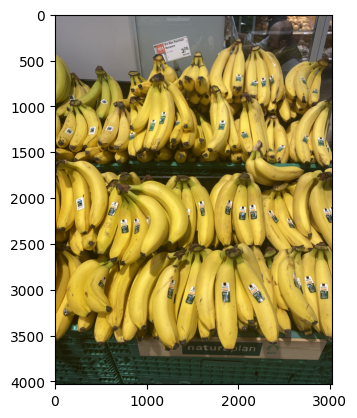

predicted class 猕猴桃, score = 0.4718630611896515


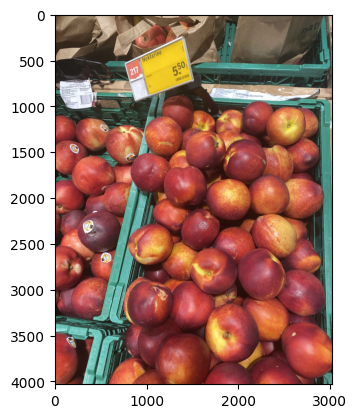

predicted class 黄瓜, score = 0.6168965697288513


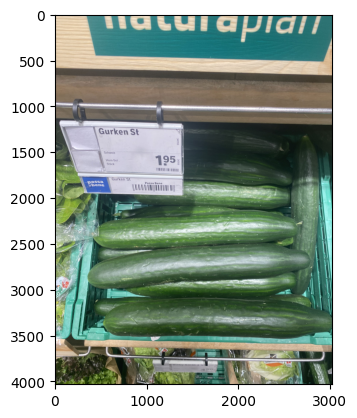

predicted class 柠檬, score = 0.5859736800193787


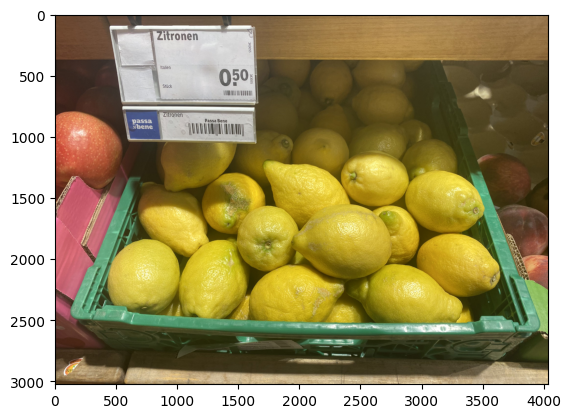

In [25]:
import cv2
from matplotlib import pyplot as plt
from mmpretrain import ImageClassificationInferencer as classifier

model = classifier(model='Models//ResNet50//mmpretrain_fruit.py', 
                   pretrained='Models//ResNet50//best_accuracy_top1_epoch_156.pth')
images = os.listdir('Test')
images = [os.path.join('Test', image) for image in images]
results = model(images, batch_size=4, show_dir='Results')

for idx, result in enumerate(results):
    print(f"predicted class {result['pred_class']}, score = {result['pred_score']}")
    plt.imshow(cv2.cvtColor(cv2.imread(images[idx]), cv2.COLOR_RGB2BGR))
    plt.show()